# Case 3 - BK Auto

Student: Parth Agarwal

Student ID: 1001303127

Course: RSM2409

Professor: Dmitry Krass

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from datetime import date
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

np.set_printoptions(precision=5)

## Data exploration

Read in 'bkauto.csv'. `RepairCost` column has NAs and these are filled in as 0, indicating no repairs were done.

Two columns have no `TerminationDate` and they were dropped for ease of handling the rest of the data.

In [55]:
df = pd.read_csv('bkauto.csv',na_values=['#VALUE!'],parse_dates=['ContractStartDate','TerminationDate','SaleDate'])
df['RepairCost'] = df['RepairCost'].fillna(0)
df['TerminationType'] = df['TerminationType'].str.replace(' ', '_')
df=df.rename(columns={'CarAccident?':'CarAccident'})
df = df.dropna()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17367 entries, 0 to 17368
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   VIN_#              17367 non-null  int64         
 1   ContractStartDate  17367 non-null  datetime64[ns]
 2   TerminationDate    17367 non-null  datetime64[ns]
 3   SaleDate           17367 non-null  datetime64[ns]
 4   TerminationType    17367 non-null  object        
 5   PurchasingRegion   17367 non-null  int64         
 6   ModelYear          17367 non-null  int64         
 7   TrimName           17367 non-null  object        
 8   ModelName          17367 non-null  object        
 9   SalesChannel       17367 non-null  object        
 10  CarAccident        17367 non-null  object        
 11  RepairCost         17367 non-null  float64       
 12  Odometer           17367 non-null  int64         
 13  PurchasePrice      17367 non-null  int64         
 14  MSRP  

In [57]:
df['RealizedValue'] = df['MSRP']/df['PurchasePrice']
df['Age'] = date.today().year - df['ModelYear']
df['YearsDriven'] = (df['TerminationDate'] - df['ContractStartDate']).dt.days/365
df.head()

,VIN_#,ContractStartDate,TerminationDate,SaleDate,TerminationType,PurchasingRegion,ModelYear,TrimName,ModelName,SalesChannel,CarAccident,RepairCost,Odometer,PurchasePrice,MSRP,RealizedValue,Age,YearsDriven
0,6428,2014-09-30,2018-08-31,2018-10-31,Terminated_at_End_of_Maturity,3,2001,TRIM_2,MODEL_C,H,Mild,500.0,61000,17000,41000,2.411765,21,3.920548
1,6429,2014-09-30,2018-02-28,2018-03-31,Terminated_at_End_of_Maturity,3,2001,TRIM_2,MODEL_C,H,No,400.0,76000,16000,40000,2.500000,21,3.416438
2,6430,2014-11-30,2018-11-30,2018-12-31,Terminated_at_End_of_Maturity,2,2001,TRIM_2,MODEL_C,E,Major,0.0,50000,16000,36000,2.250000,21,4.002740
3,6431,2014-10-31,2018-10-31,2018-11-30,Terminated_at_End_of_Maturity,2,2001,TRIM_2,MODEL_C,F,No,0.0,47000,18000,40000,2.222222,21,4.002740
4,6432,2014-10-31,2018-10-31,2018-10-31,Terminated_at_End_of_Maturity,2,2001,TRIM_2,MODEL_C,G,Moderate,0.0,75000,14000,36000,2.571429,21,4.002740


In [58]:
df_by_year = df.groupby(df['SaleDate'].dt.year).mean().drop(columns=['VIN_#','PurchasingRegion','ModelYear'])
df_by_year.head()

,RepairCost,Odometer,PurchasePrice,MSRP,RealizedValue,Age,YearsDriven
SaleDate,,,,,,,
2016,186.206897,43948.275862,24620.689655,47982.758621,2.006723,21.741379,2.555503
2017,197.703549,51044.189283,22218.510786,47527.139875,2.198168,21.815936,3.070704
2018,213.233523,57320.426777,19408.707623,46777.663053,2.469165,21.583204,3.598834
2019,262.934216,54969.589006,19595.113882,49427.153582,2.602040,20.520550,3.429903
2020,165.490196,54819.607843,19192.156863,51698.039216,2.779087,19.839216,3.483273


Plots of various parameters by year.

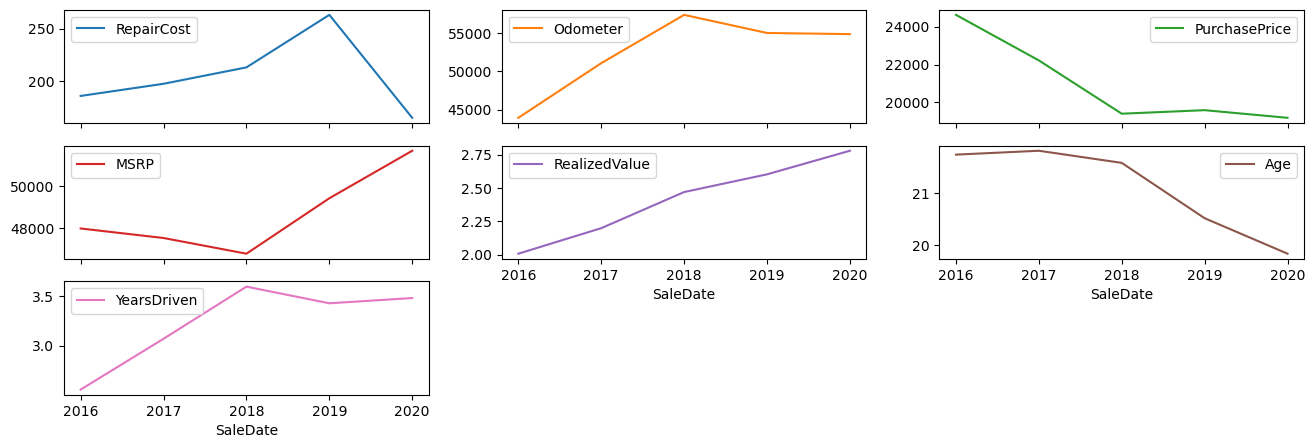

In [59]:
df_by_year.plot(layout=(3,3),subplots=True,figsize=(16,5))
plt.show()

Histogram plot for shortlisted predictors shows relatively normally distributions for `RealizedValue` and key variables.

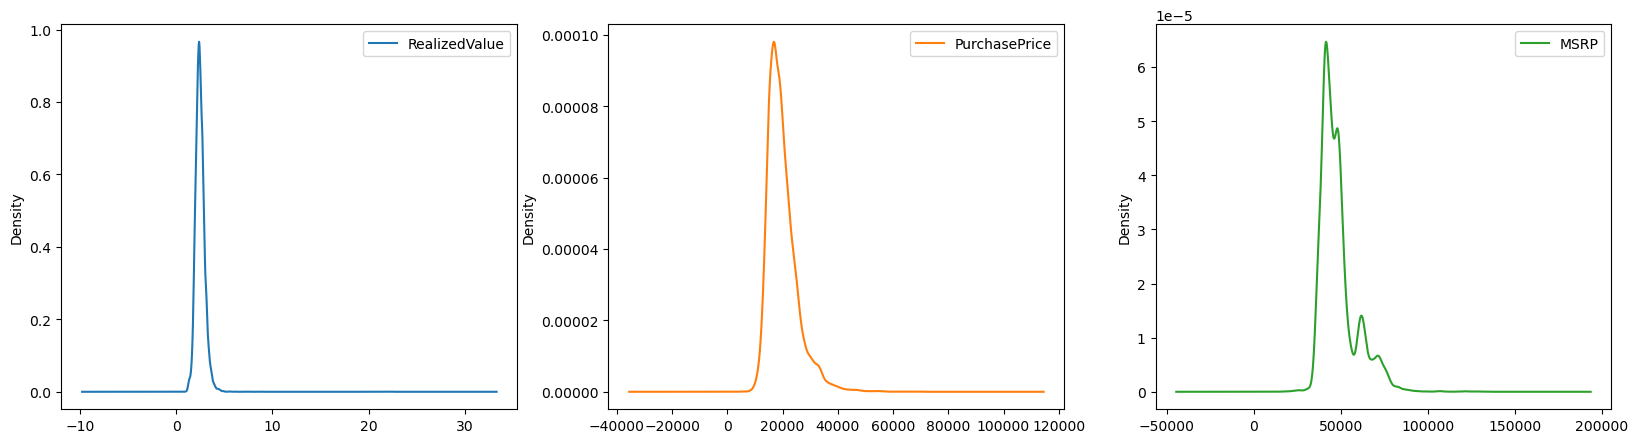

In [60]:
df[['RealizedValue','PurchasePrice','MSRP']].plot.density(layout=(1,3),subplots=True,figsize=(20,5),sharex=False, sharey=False)
plt.show()

## Data analysis

Partition data into `training` and `validation` with a 50/50 split.

In [61]:
predictors=['TerminationType', 'PurchasingRegion', 'TrimName', 'ModelName', 'SalesChannel', 'CarAccident', 'RepairCost', 'Odometer', 'Age', 'YearsDriven']
outcome = 'RealizedValue'

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.5,random_state=1)
print("Training   : ", train_X.shape)
print("Validation : ", valid_X.shape)

Training   :  (8683, 37)
Validation :  (8684, 37)


Various models are shown below with similar performance - backward selection is chosen and the rest of the options are minimized.
- With all variables
- Forward selection
- Stepwise selection
- Lasso regression
- Ridge regression
- Backward selection

### Regression on all variables

In [62]:
lm = LinearRegression()
lm.fit(train_X, train_y)

regressionSummary(train_y, lm.predict(train_X))
print('Intercept: {:.5} \nR^2: {:.5}'.format(lm.intercept_,lm.score(X, y)))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.2893
            Mean Absolute Error (MAE) : 0.2122
          Mean Percentage Error (MPE) : -1.0827
Mean Absolute Percentage Error (MAPE) : 8.4985
Intercept: 3.2693 
R^2: 0.56145


### Forward selection

In [63]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model,score_model,verbose=False)
print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

['Odometer', 'YearsDriven', 'ModelName_MODEL_B', 'SalesChannel_H', 'Age', 'ModelName_MODEL_C', 'CarAccident_No', 'TrimName_TRIM_8', 'TrimName_TRIM_18', 'CarAccident_Moderate', 'SalesChannel_G', 'CarAccident_Mild', 'PurchasingRegion', 'TrimName_TRIM_15', 'TrimName_TRIM_2', 'TrimName_TRIM_7', 'TrimName_TRIM_3', 'SalesChannel_F', 'RepairCost', 'TrimName_TRIM_16', 'TrimName_TRIM_19', 'TrimName_TRIM_12', 'TrimName_TRIM_4', 'TrimName_TRIM_5', 'SalesChannel_D', 'SalesChannel_B', 'TrimName_TRIM_9', 'TrimName_TRIM_14']

Regression statistics

                      Mean Error (ME) : 0.0067
       Root Mean Squared Error (RMSE) : 0.3688
            Mean Absolute Error (MAE) : 0.2218
          Mean Percentage Error (MPE) : -0.9553
Mean Absolute Percentage Error (MAPE) : 8.7802


### Stepwise selection

In [64]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model,score_model, verbose=False)
print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

['Odometer', 'YearsDriven', 'ModelName_MODEL_B', 'SalesChannel_H', 'Age', 'ModelName_MODEL_C', 'CarAccident_No', 'TrimName_TRIM_8', 'TrimName_TRIM_18', 'CarAccident_Moderate', 'SalesChannel_G', 'CarAccident_Mild', 'PurchasingRegion', 'TrimName_TRIM_15', 'TrimName_TRIM_2', 'TrimName_TRIM_7', 'TrimName_TRIM_3', 'SalesChannel_F', 'RepairCost', 'TrimName_TRIM_16', 'TrimName_TRIM_19', 'TrimName_TRIM_12', 'TrimName_TRIM_4', 'TrimName_TRIM_5', 'SalesChannel_D', 'SalesChannel_B', 'TrimName_TRIM_9', 'TrimName_TRIM_14']

Regression statistics

                      Mean Error (ME) : 0.0067
       Root Mean Squared Error (RMSE) : 0.3688
            Mean Absolute Error (MAE) : 0.2218
          Mean Percentage Error (MPE) : -0.9553
Mean Absolute Percentage Error (MAPE) : 8.7802


### Lasso regression

In [65]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0051
       Root Mean Squared Error (RMSE) : 0.5234
            Mean Absolute Error (MAE) : 0.3639
          Mean Percentage Error (MPE) : -3.4735
Mean Absolute Percentage Error (MAPE) : 15.0098


### Ridge regression

In [66]:
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
alpha = bayesianRidge.lambda_ / bayesianRidge.alpha_
print('Bayesian ridge chosen regularization: {:.5f}'.format(alpha))


Regression statistics

                      Mean Error (ME) : 0.0068
       Root Mean Squared Error (RMSE) : 0.3686
            Mean Absolute Error (MAE) : 0.2219
          Mean Percentage Error (MPE) : -0.9590
Mean Absolute Percentage Error (MAPE) : 8.7845
Bayesian ridge chosen regularization: 0.00220


### Backward selection

In [67]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
    
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, train_model,score_model, verbose=False)
print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

['PurchasingRegion', 'RepairCost', 'Odometer', 'Age', 'YearsDriven', 'TerminationType_Terminated_Prior_to_Maturity_Date', 'TerminationType_Terminated_at_End_of_Maturity', 'TrimName_TRIM_12', 'TrimName_TRIM_14', 'TrimName_TRIM_15', 'TrimName_TRIM_16', 'TrimName_TRIM_18', 'TrimName_TRIM_19', 'TrimName_TRIM_2', 'TrimName_TRIM_3', 'TrimName_TRIM_4', 'TrimName_TRIM_5', 'TrimName_TRIM_7', 'TrimName_TRIM_8', 'TrimName_TRIM_9', 'ModelName_MODEL_B', 'ModelName_MODEL_C', 'SalesChannel_B', 'SalesChannel_D', 'SalesChannel_F', 'SalesChannel_G', 'SalesChannel_H', 'CarAccident_Mild', 'CarAccident_Moderate', 'CarAccident_No']

Regression statistics

                      Mean Error (ME) : 0.0067
       Root Mean Squared Error (RMSE) : 0.3687
            Mean Absolute Error (MAE) : 0.2220
          Mean Percentage Error (MPE) : -0.9553
Mean Absolute Percentage Error (MAPE) : 8.7900


### OLS Regression

Linear regression is run using the reduced predictor set derived from backwards selection. The Adj. R^2 value is good, and all of the predictors in this set are significant below 5%.


The coefficients and their signage are reasonable. Higher t-values indicate higher predictor strength. The highest t-values are the `odometer`, `years driven`, and `age`. Higher mileage, more years driven, and higher age indicate higher realized value, which are intuitively the opposite for the car’s resale value.


It should be noted that car model B and C have fairly high coefficients (their coefficients can be compared since they are dummy variables and therefore standardized). Model B appears to be a positive predictor for realized value, and model C a negative predictor.

In [68]:
train_df = train_X[best_variables].join(train_y)
predictors = best_variables
formula = outcome + ' ~ '+' + '.join(predictors)
lm = sm.ols(formula=formula, data=train_df).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          RealizedValue   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     493.0
Date:                Thu, 24 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:08:24   Log-Likelihood:                -1551.7
No. Observations:                8683   AIC:                             3165.
Df Residuals:                    8652   BIC:                             3385.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             3.2676      0.088     37.097      0.000       3.095       3.440
PurchasingRegion                                      0.0405      0.008      5.213      0.000       0.025       0.056
RepairCost                                        -2.338e-05   9.12e-06     -2.564      0.010   -4.12e-05   -5.51e-06
Odometer                                           8.886e-06   1.64e-07     54.203      0.000    8.56e-06    9.21e-06
Age                                                  -0.1190      0.004    -28.724      0.000      -0.127      -0.111
YearsDriven                                           0.3715      0.006     58.527      0.000       0.359       0.384
TerminationType_Terminated_Prior_to_Maturity_Date    -0.0720      0.025     -2.866      0.004      -0.121      -0.023
TerminationType_Terminated_at_End_of_Maturity        -0.0634      0.025     -2.573      0.010      -0.112      -0.015
TrimName_TRIM_12                                     -0.0622      0.026     -2.365      0.018      -0.114      -0.011
TrimName_TRIM_14                                      0.0724      0.050      1.448      0.148      -0.026       0.170
TrimName_TRIM_15                                     -0.1996      0.036     -5.596      0.000      -0.269      -0.130
TrimName_TRIM_16                                     -0.5139      0.206     -2.500      0.012      -0.917      -0.111
TrimName_TRIM_18                                     -0.2084      0.026     -7.951      0.000      -0.260      -0.157
TrimName_TRIM_19                                      0.2137      0.104      2.064      0.039       0.011       0.417
TrimName_TRIM_2                                       0.0769      0.013      5.950      0.000       0.052       0.102
TrimName_TRIM_3                                       0.0445      0.017      2.695      0.007       0.012       0.077
TrimName_TRIM_4                                      -0.0892      0.045     -1.991      0.046      -0.177      -0.001
TrimName_TRIM_5                                      -0.0388      0.018     -2.106      0.035      -0.075      -0.003
TrimName_TRIM_7                                       0.0559      0.014      4.021      0.000       0.029       0.083
TrimName_TRIM_8                                      -0.2957      0.030     -9.828      0.000      -0.355      -0.237
TrimName_TRIM_9                                      -0.1250      0.076     -1.653      0.098      -0.273       0.023
ModelName_MODEL_B                                     0.3442      0.015     23.628      0.000       0.316       0.373
ModelName_MODEL_C                                    -0.1895      0.009    -20.357      0.000      -0.208      -0.171
SalesChannel_B 

Residuals for the regression against the validation data are plotted.

X-axis limit set manually to ignore an outlier residual with 17.5 error.


Regression statistics

                      Mean Error (ME) : 0.0067
       Root Mean Squared Error (RMSE) : 0.3687
            Mean Absolute Error (MAE) : 0.2220
          Mean Percentage Error (MPE) : -0.9553
Mean Absolute Percentage Error (MAPE) : 8.7900


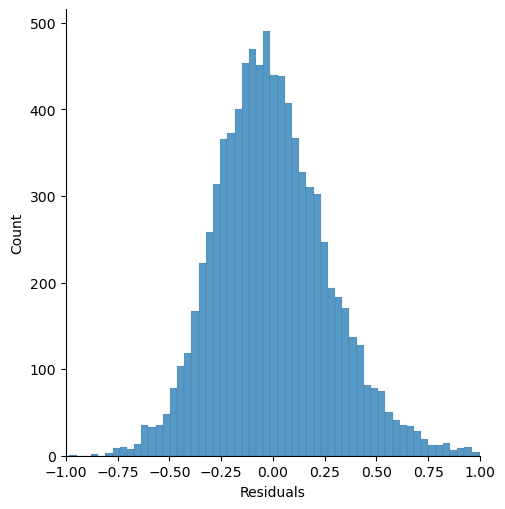

In [69]:
lm_pred = lm.predict(valid_X)
regressionSummary(valid_y, lm_pred)
all_residuals = valid_y - lm_pred
sns.displot(all_residuals)
plt.axvline(2.8, 0,0.17)
plt.xlim(-1,1)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()